## Import modules and Load Data

In [1]:
# Import modules
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adam
import json
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load csv files
steer_angles = []
center_path = []
left_path = []
right_path = []
ANGLE_OFFSET = 0.24
COL = 64
ROW = 64

with open('data/driving_log.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for line in reader:
        steer_angles.append(float(line['steering']))
        center_path.append('data/' + line['center'])
        left_path.append('data/' + line['left'].split(' ')[1])
        right_path.append('data/' + line['right'].split(' ')[1])

## Data Exploration and Visulization

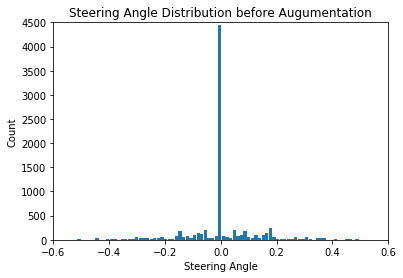

Length of original dataset is 8036


In [3]:
# Plot the histogram on training label
plt.axis([-0.6, 0.6, 0, 4500])
plt.hist(steer_angles, bins = 150, rwidth=0.9)
plt.xlabel('Steering Angle')
plt.ylabel('Count')
plt.title('Steering Angle Distribution before Augumentation')
plt.show()
print('Length of original dataset is {}'.format(len(steer_angles)))

Length of abs. angle 0.002 dataset is 4361


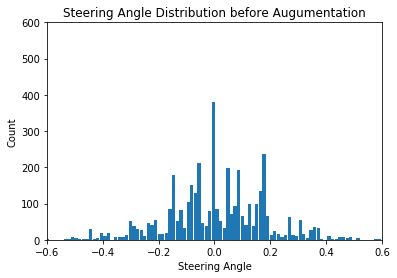

Length of new dataset is 3975


In [4]:
angle_small = []
new_data = []
new_center_path = []
new_left_path = []
new_right_path = []
angle_thres = 0.002

for i in range(len(steer_angles)):
    angle = steer_angles[i]
    center = center_path[i]
    left = left_path[i]
    right = right_path[i]
    
    # Only store angle greater than threshold to new array
    if abs(angle) <= angle_thres:
        angle_small.append(angle)
    else:
        new_data.append(angle)
        new_center_path.append(center)
        new_left_path.append(left)
        new_right_path.append(right)
        
print('Length of abs. angle {} dataset is {}'.format(angle_thres, len(angle_small)))   

# Only pick 500 samples out of lower or equal to threshold dataset
for i in range(300):
    rand_idx = np.random.randint(len(angle_small))
    new_data.append(angle_small[rand_idx])
    new_center_path.append(center)
    new_left_path.append(left)
    new_right_path.append(right)
    
# Plot the histogram on training label
plt.axis([-0.6, 0.6, 0, 600])

plt.hist(new_data, bins = 150, rwidth=0.9)
plt.xlabel('Steering Angle')
plt.ylabel('Count')
plt.title('Steering Angle Distribution before Augumentation')
plt.show()
print('Length of new dataset is {}'.format(len(new_data))) 
steer_angles = new_data
center_path = new_center_path
left_path = new_left_path
right_path = new_right_path

In [5]:
# # Remove 15% zero-steering-angle data
# new_steer_angles = []
# new_center_path = []
# new_left_path = []
# new_right_path = []
# # left_path_idx = []
# # right_path_idx = []
# for i in range(0, len(steer_angles)):
#     angle = steer_angles[i]
#     center = center_path[i]
#     left = left_path[i]
#     right = right_path[i]
#     if abs(angle) <= 0.01:
#         if np.random.uniform() >= 0.85:
#             new_steer_angles.append(angle)
#             new_center_path.append(center)
#             new_left_path.append(left)
#             new_right_path.append(right)
#     else:
#         new_steer_angles.append(angle)
#         new_center_path.append(center)
#         new_left_path.append(left)
#         new_right_path.append(right)
        
# steer_angles = new_steer_angles
# center_path = new_center_path
# left_path = new_left_path
# right_path = new_right_path
# print('Length of new dataset is {}'.format(len(steer_angles)))

In [6]:
# # Plot the histogram on training label after removing 85% zero angles
# plt.axis([-0.6, 0.6, 0, 750])
# plt.hist(new_steer_angles, bins = 100, rwidth=0.9)
# plt.xlabel('Steering Angle')
# plt.ylabel('Count')
# plt.title('Steering Angle Distribution after Augumentation')
# plt.show()

In [7]:
# Load and transform image into GRB format
def load_img(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

In [8]:
# Plot left, center and right image with angles
def visualize_img(rand_idx):
    center_img = load_img(center_path[rand_idx])
    left_img = load_img(left_path[rand_idx])
    right_img = load_img(right_path[rand_idx])
    
    center_angle = steer_angles[rand_idx]
    left_angle = center_angle + ANGLE_OFFSET
    right_angle = center_angle - ANGLE_OFFSET
    
    # Plot left img
    plt.subplot(1,3,1)
    plt.imshow(left_img)
    plt.title('Left Image & angle is {:.2f}'.format(left_angle))
    plt.axis('off')

    # Plot center img
    plt.subplot(1,3,2)
    plt.imshow(center_img)
    plt.title('Center Image & angle is {:.2f}'.format(center_angle))
    plt.axis('off')

    # Plot right img
    plt.subplot(1,3,3)
    plt.imshow(right_img)
    plt.title('Right Image & angle is {:.2f}'.format(right_angle))
    plt.axis('off')

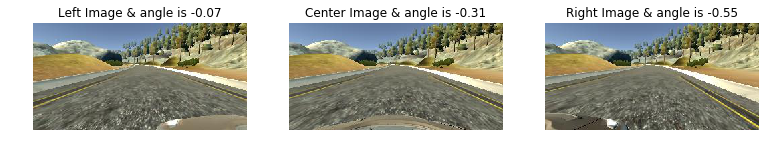

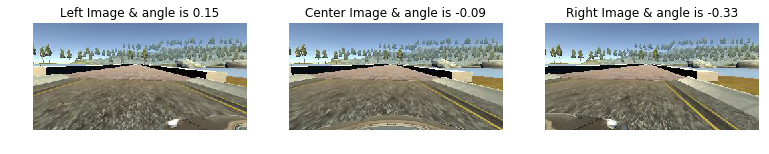

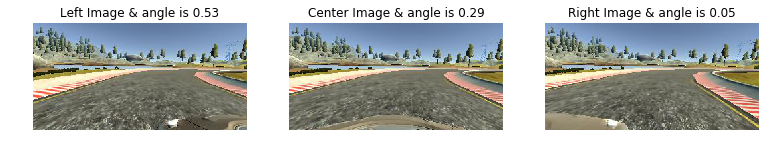

In [9]:
for index in range(3):
    rand_idx = np.random.randint(len(center_path))
    plt.figure(figsize=(13,3))
    visualize_img(rand_idx)

## Data Agumentation

In [10]:
# Randomly adjust brightness
def adjust_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    rand_brightness_coeff = 0.25 + np.random.uniform(0.3, 1) # Range [0.55, 1.25]
    img[:,:,2] = img[:,:,2] * rand_brightness_coeff
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [11]:
# Randomly flip images horizontally to combat most straight driving
def rand_flip(img, angle):
    new_img = np.array(img)
    new_angle = angle
    if np.random.randint(2) == 0:
        new_img = cv2.flip(img,1)
        new_angle = -angle
    return new_img, new_angle

In [12]:
# Randomly shift images horizontally and vertically
# http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
def rand_shift(img, angle):
    rows, cols = img.shape[0:2]
    max_dx = 50
    angle_pixel = 0.003 #steering angle per pixel, add when shift to right, minus when to left
    dx = max_dx * np.random.uniform() - 0.5*max_dx #Range is [-25, 25] in x direction
    dy = 30 * np.random.uniform() - 15 #Range is [-15, 15] in y direction
    new_angle = angle + dx * angle_pixel
    M = np.float32([[1,0,dx],[0,1,dy]]) #Tranformation matrix
    dst_img = cv2.warpAffine(img, M, (cols,rows))
    return dst_img, new_angle

In [13]:
# Radomly add shadow
def rand_shadow(img):
    length_y, length_x = img.shape[0:2]
    shadow_poly = np.array(img)
    shadow_img = np.array(img)

    if np.random.randint(2) == 0:    
        x_top_left = np.random.randint(0, 0.5 * length_x)
        x_top_right = np.random.randint(0.5 * length_x, length_x)
        y_top = 0

        x_bottom_left = np.random.randint(0, 0.5 * length_x)
        x_bottom_right = np.random.randint(0.5 * length_x, length_x)
        y_bottom = length_y

        vertices = np.array([[x_top_left, y_top],[x_bottom_left, y_bottom],[x_bottom_right ,y_bottom],[x_top_right, y_top]])

        cv2.fillPoly(shadow_poly, [vertices],-1)
        alpha = np.random.uniform(0.5,0.8)
        gamma =  1 - alpha
        cv2.addWeighted(shadow_poly, alpha, img, gamma,0, shadow_img)
    return shadow_img

In [14]:
# Resize image
def resize_img(img):
    rows, cols = img.shape[0:2]
    # Remove the top 40 pixels and the bottom 20 pixels
    cropped_img = img[60:140, 0:cols, :]
    resized_img = cv2.resize(cropped_img, (COL,ROW), interpolation=cv2.INTER_AREA)
    return resized_img

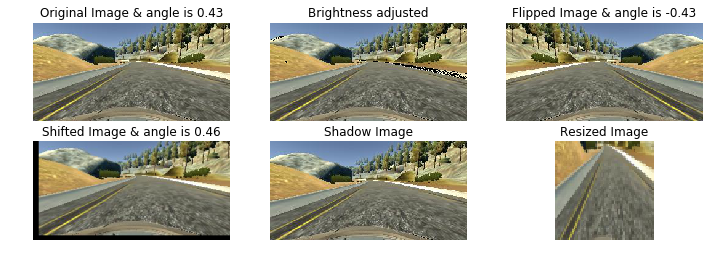

In [15]:
# Plot augumented images
rand_idx = np.random.randint(len(steer_angles))
ref_img = load_img(center_path[rand_idx])
ref_angle = steer_angles[rand_idx]
bright_img = adjust_brightness(ref_img)
flip_img, flip_angle = rand_flip(ref_img, ref_angle)
shift_img, shift_angle = rand_shift(ref_img, ref_angle)
shadow_img = rand_shadow(ref_img)
resized_img = resize_img(ref_img)
# Original
plt.figure(figsize=(12,4))
plt.subplot(2,3,1)
plt.imshow(ref_img)
plt.axis('off')
plt.title('Original Image & angle is {:.2f}'.format(ref_angle))


# Brightness adjusted
plt.subplot(2,3,2)
plt.imshow(bright_img)
plt.axis('off')
plt.title('Brightness adjusted')

# Flipped
plt.subplot(2,3,3)
plt.imshow(flip_img)
plt.axis('off')
plt.title('Flipped Image & angle is {:.2f}'.format(flip_angle))

# Shifted
plt.subplot(2,3,4)
plt.imshow(shift_img)
plt.axis('off')
plt.title('Shifted Image & angle is {:.2f}'.format(shift_angle))

# Shadow
plt.subplot(2,3,5)
plt.imshow(shadow_img)
plt.axis('off')
plt.title('Shadow Image')

# Resized
plt.subplot(2,3,6)
plt.imshow(resized_img)
plt.axis('off')
plt.title('Resized Image')
plt.show()

In [16]:
# Generate left and right path given center path
def generate_left_right(center_path):
    left_path = []
    right_path = []
    for string in center_path:
        left_path.append(str.replace(string,'center','left'))
        right_path.append(str.replace(string,'center','right'))
    return left_path, right_path

In [17]:
# Generate single training images
def generate_single_training_data(steer_angles, center_path):
    rand_number = np.random.randint(len(steer_angles))
    
    left_path, right_path = generate_left_right(center_path)
    
    rand_idx = np.random.randint(3)
    if rand_idx == 0:
        img = load_img(center_path[rand_number])
        angle = steer_angles[rand_number]
    elif rand_idx == 1:
        img = load_img(left_path[rand_number])
        angle = steer_angles[rand_number] + ANGLE_OFFSET
    else:
        img = load_img(right_path[rand_number])
        angle = steer_angles[rand_number] - ANGLE_OFFSET
        
    img = adjust_brightness(img)
    img, angle = rand_flip(img, angle)
    img, angle = rand_shift(img, angle)
    img = rand_shadow(img)
    img = resize_img(img)
    return img, angle

In [18]:
#plt.figure(figsize=(6,6))
post_data = []
for i in range(2000):
    img, angle = generate_single_training_data(steer_angles, center_path)
#     plt.subplot(6,5,i+1)
#     plt.imshow(img)
#     plt.axis('off')
    post_data.append(angle)

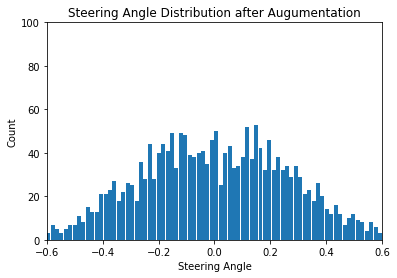

In [19]:
# Plot the histogram on training label after removing 85% zero angles
plt.axis([-0.6, 0.6, 0, 100])
plt.hist(post_data, bins = 150, rwidth=0.9)
plt.xlabel('Steering Angle')
plt.ylabel('Count')
plt.title('Steering Angle Distribution after Augumentation')
plt.show()

In [20]:
# Generate batch training images
def generate_batch_training_data(steer_angles, center_path, batch_size):
    steer_angles, center_path = shuffle(steer_angles, center_path)
    images = np.zeros((batch_size, COL, ROW, 3))
    angles = np.zeros(batch_size)
    
    while 1:
        for i in range(batch_size):
            img, angle = generate_single_training_data(steer_angles, center_path)
            images[i] = img
            angles[i] = angle
        img_train = np.array(images)
        angle_train = np.array(angles)
        yield img_train, angle_train

In [21]:
# Generate batch validation images
def generate_batch_val_data(img_val, angle_val):
    
    angle_val, img_val = shuffle(angle_val, img_val)
    
    images = []
    angles = []
    for i in range(len(img_val)):
        img = load_img(img_val[i])
        img = resize_img(img)
        angle = angle_val[i]
        images.append(img)
        angles.append(angle)
    img_val = np.array(images)
    angle_val = np.array(angles)
    return img_val, angle_val

## Convolutional Neural Network Model

In [22]:
# Define model
model = Sequential()
model.add(Lambda(lambda x: (x/127.5) - 1, input_shape=(COL, ROW, 3)))

# 1st Convolutional layer
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))
# 2nd@ Convolutional layer
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))
# 3rd@ Convolutional layer
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))
# 4th@ Convolutional layer
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Flatten())
# FC1@512
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# FC2@128
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# FC3@32
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 64, 32)    896         lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 32, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 32)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [23]:
# Split training and validation dataset
#center_path, left_path, right_path, steer_angles = shuffle(center_path, left_path, right_path, steer_angles)
img_train, img_val, angle_train, angle_val = train_test_split(center_path, steer_angles, test_size = 0.2, random_state = 0)

print('number of training dataset is {}'.format(len(center_path)))
print('number of training dataset is {}'.format(len(steer_angles)))
print('number of training dataset is {}'.format(len(img_train)))
print('number of validation dataset is {}'.format(len(img_val)))

number of training dataset is 3975
number of training dataset is 3975
number of training dataset is 3180
number of validation dataset is 795


In [24]:
EPOCH = 4
BATCH = 256
NUMSAMEPOCH = BATCH * 80

train_generator = generate_batch_training_data(angle_train, img_train, BATCH)
img_validation, angle_validation = generate_batch_val_data(img_val, angle_val)

In [25]:
# for i in range(50):
#     next(train_generator)
# img, steer = next(train_generator)
# print(len(img))
# plt.imshow(img[0])

In [26]:
# Train model
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer='adam')

history = model.fit_generator(train_generator,
                              samples_per_epoch=NUMSAMEPOCH,
                              validation_data=(img_validation, angle_validation),
                              nb_epoch=EPOCH, verbose=1)

Epoch 1/4
20480/20480 [==============================] - 137s - loss: 0.0628 - val_loss: 0.0206

In [28]:
model_json = 'model.json'
model_weights = 'model.h5'
json_string = model.to_json()

try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass


with open(model_json, 'w') as outfile:
    json.dump(json_string, outfile)
model.save(model_weights)
